In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
import yfinance as yf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
sns.set()

In [3]:
btc_data = yf.download("BTC-USD", period="max")

[*********************100%***********************]  1 of 1 completed


In [4]:
btc_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2912 entries, 2014-09-17 to 2022-09-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2912 non-null   float64
 1   High       2912 non-null   float64
 2   Low        2912 non-null   float64
 3   Close      2912 non-null   float64
 4   Adj Close  2912 non-null   float64
 5   Volume     2912 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 159.2 KB


In [6]:
btc_data.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2022-08-28', '2022-08-29', '2022-08-30', '2022-08-31',
               '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04',
               '2022-09-05', '2022-09-06'],
              dtype='datetime64[ns]', name='Date', length=2912, freq=None)

In [7]:
btc_data.to_csv("data/bitcoin.csv")

In [8]:
btc_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

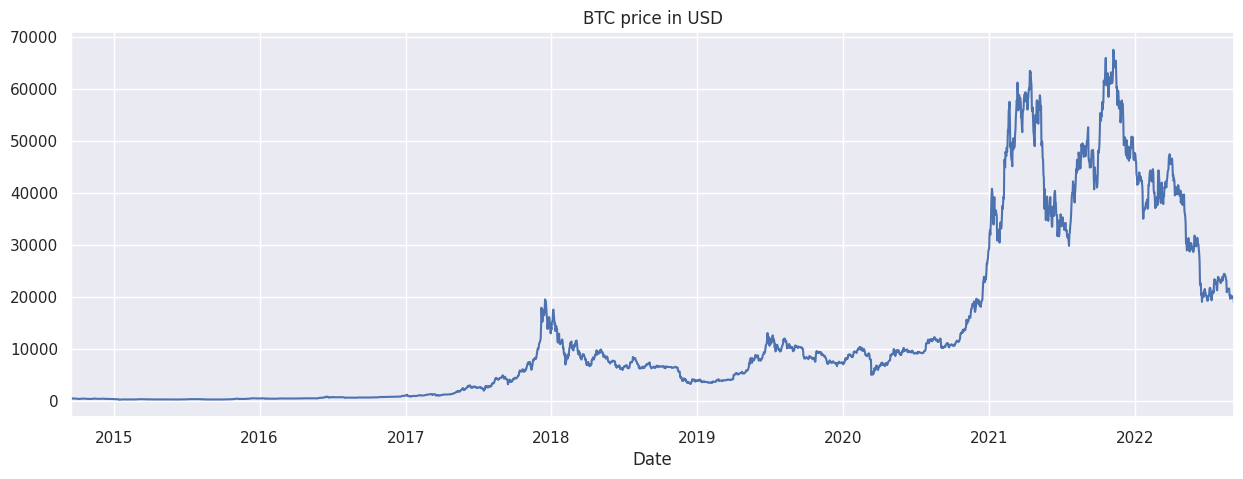

In [9]:
btc_data["Adj Close"].plot(figsize=(15,5), title="BTC price in USD")
plt.show()

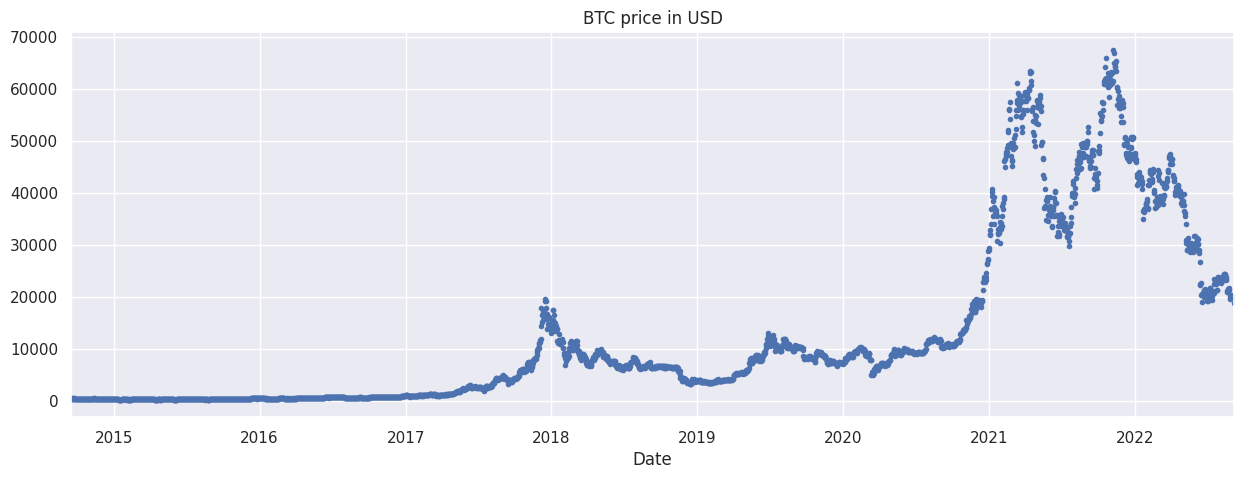

In [10]:
btc_data["Adj Close"].plot(figsize=(15,5), title="BTC price in USD", style=".")
plt.show()

In [11]:
print(f"Mean: {btc_data['Adj Close'].mean():0.2f}")
print(f"Median: {btc_data['Adj Close'].median():0.2f}")
print(f"Standard deviation: {btc_data['Adj Close'].std():0.2f}")


Mean: 12640.27
Median: 6708.94
Standard deviation: 16462.42


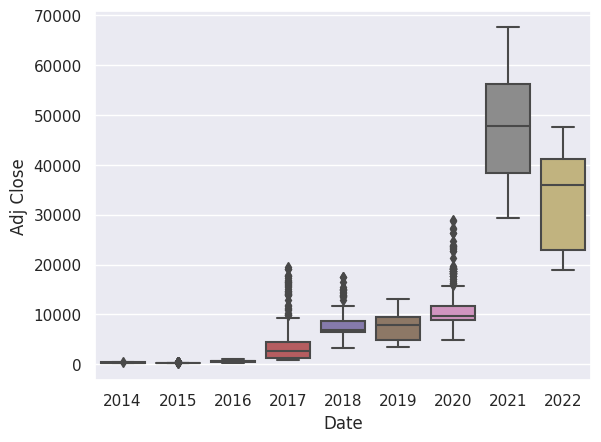

In [12]:
sns.boxplot(data=btc_data, x=btc_data.index.year, y="Adj Close")
plt.show()

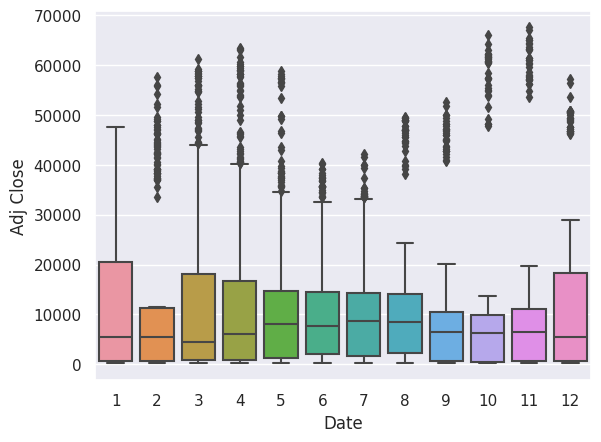

In [13]:
sns.boxplot(data=btc_data, x=btc_data.index.month, y="Adj Close")
plt.show()

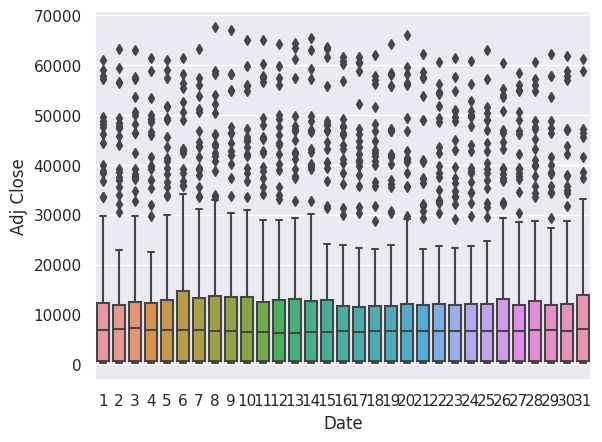

In [14]:
sns.boxplot(data=btc_data, x=btc_data.index.day, y="Adj Close")
plt.show()

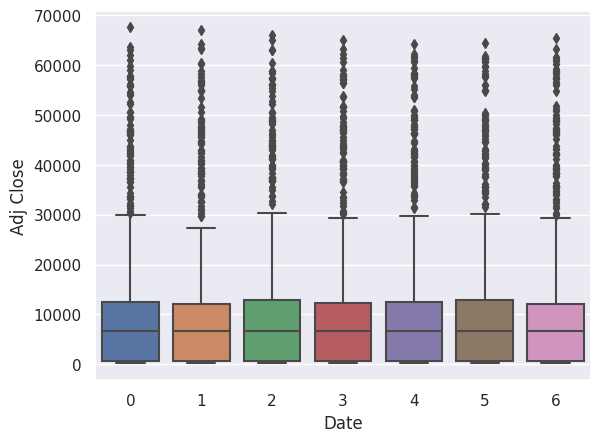

In [15]:
sns.boxplot(data=btc_data, x=btc_data.index.dayofweek, y="Adj Close")
plt.show()

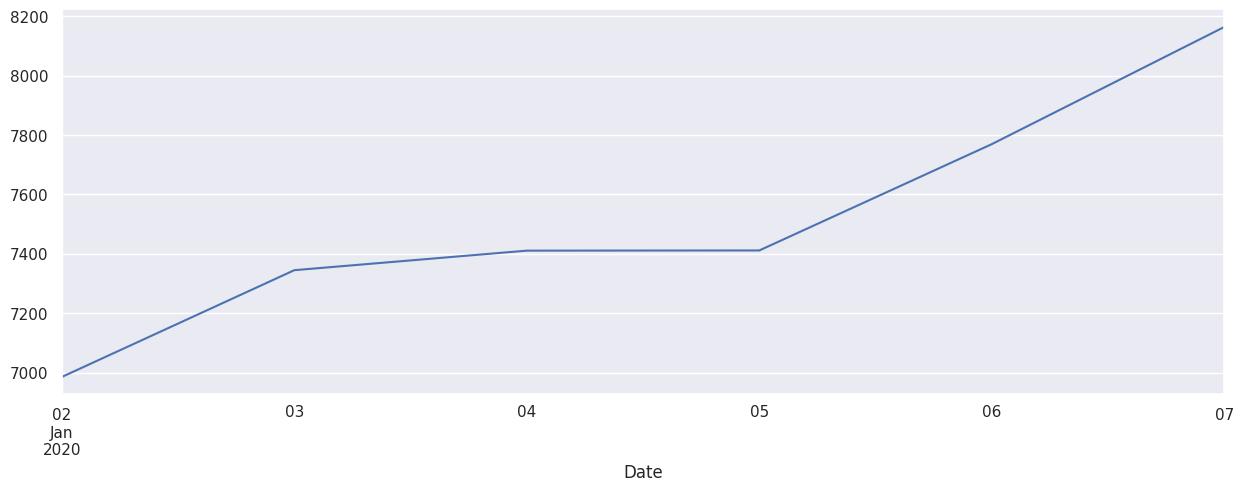

In [16]:
one_week_of_data_filter = (btc_data.index > '01-01-2020') & (btc_data.index < '01-08-2020')
btc_data["Adj Close"].loc[one_week_of_data_filter].plot(figsize=(15,5))
plt.show()

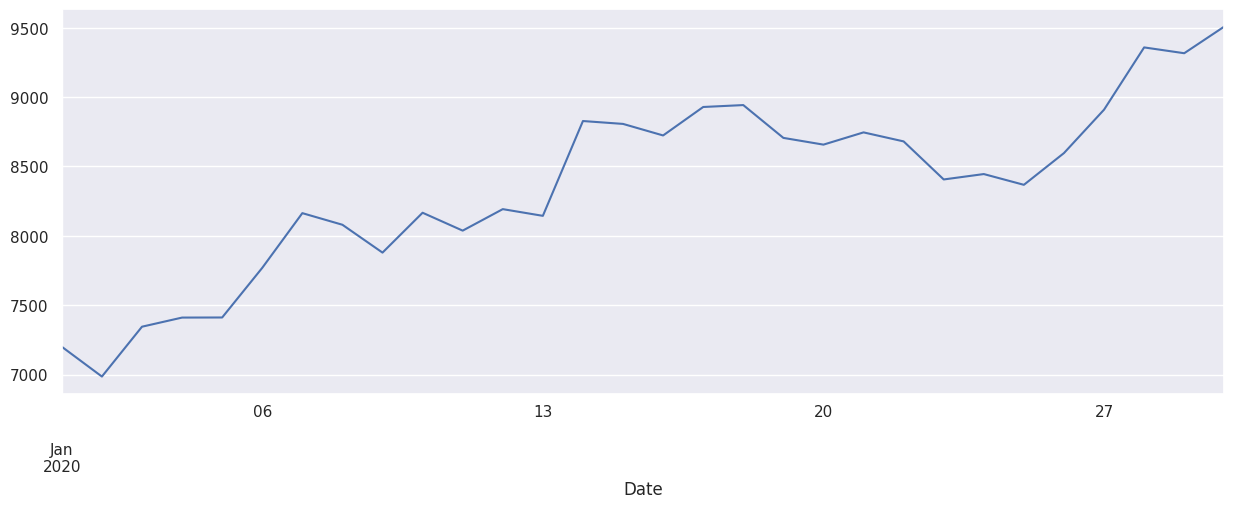

In [17]:
one_month_of_data_filter = (btc_data.index >= '01-01-2020') & (btc_data.index < '01-31-2020')
btc_data["Adj Close"].loc[one_month_of_data_filter].plot(figsize=(15,5))
plt.show()

In [18]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index 
    and adds these new features to a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame that we want to add new features.

    Returns:
        pd.DataFrame: An updated DataFrame with new features.
    """
    df = df.copy()
    
    #df["day"] = df.index.day
    #df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    #df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    
    return df

In [19]:
btc_df = btc_data[["Adj Close"]]

In [20]:
btc_df.index.max()

Timestamp('2022-09-06 00:00:00')

In [21]:
split_date_point = btc_df.index.max() - pd.Timedelta(days=30)
data_filter_less = btc_df.index < split_date_point
data_filter_geq = btc_df.index >= split_date_point

train = btc_df.loc[data_filter_less]
test = btc_df.loc[data_filter_geq]

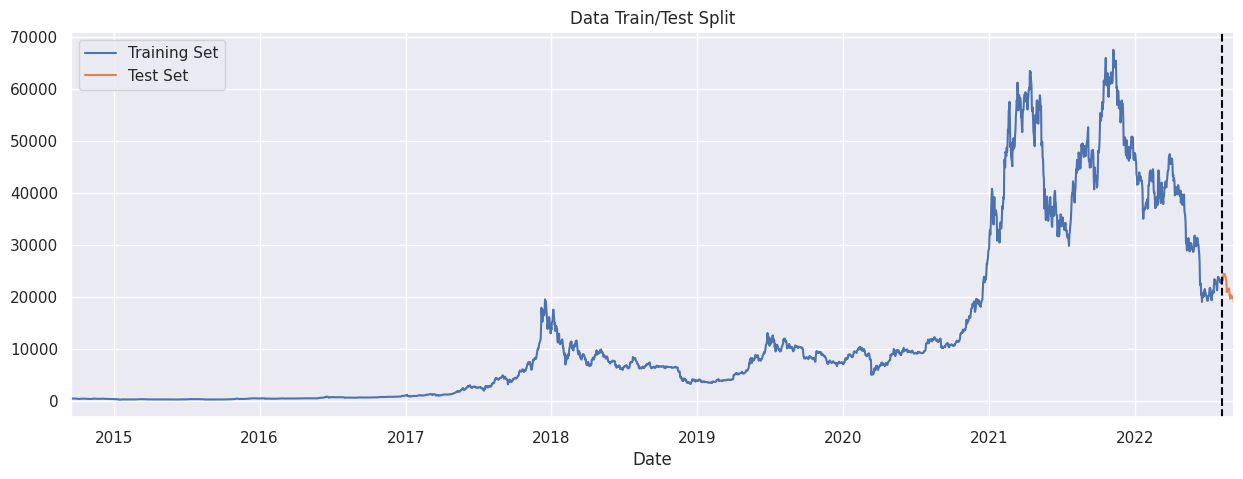

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline(split_date_point, color="black", ls="--")
ax.legend(["Training Set", "Test Set"])
plt.show()

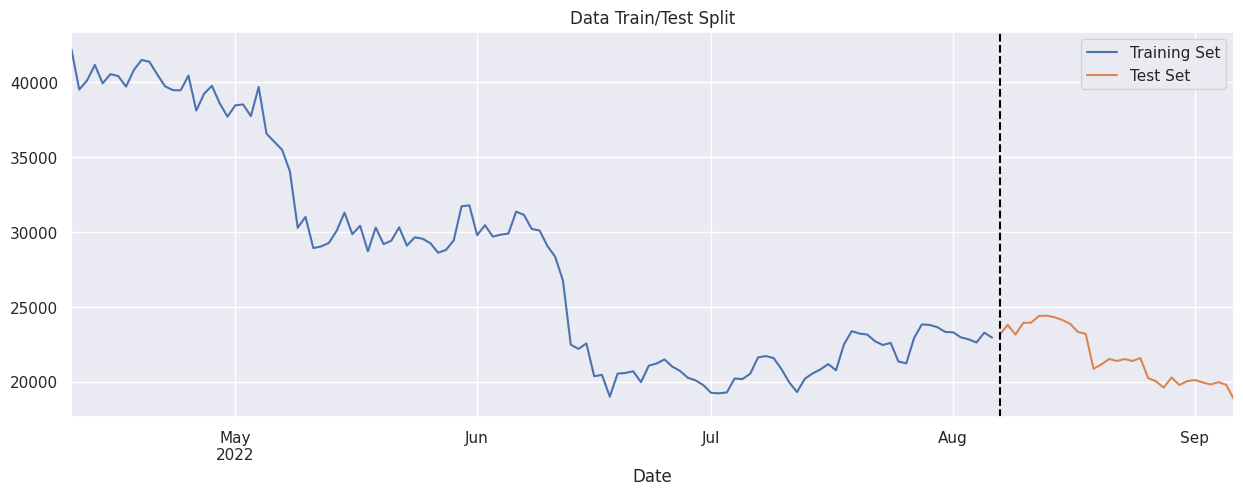

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
train[train.index > (split_date_point - pd.Timedelta(days=120))].plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test[test.index > (split_date_point - pd.Timedelta(days=120))].plot(ax=ax, label="Test Set")
ax.axvline(split_date_point, color="black", ls="--")
ax.legend(["Training Set", "Test Set"])
plt.show()

In [24]:
btc_df = create_features(df=btc_df)
train = create_features(df=train)
test = create_features(df=test)

In [25]:
FEATURES = [column for column in btc_df.columns[1:]]
TARGET = btc_df.columns[0]

In [26]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [27]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)

[0]	validation_0-rmse:20538.11761	validation_1-rmse:21601.05066
[100]	validation_0-rmse:7759.15481	validation_1-rmse:8378.92081
[200]	validation_0-rmse:3070.03007	validation_1-rmse:3045.93476
[300]	validation_0-rmse:1408.65203	validation_1-rmse:2551.80968
[302]	validation_0-rmse:1389.39465	validation_1-rmse:2583.35400


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

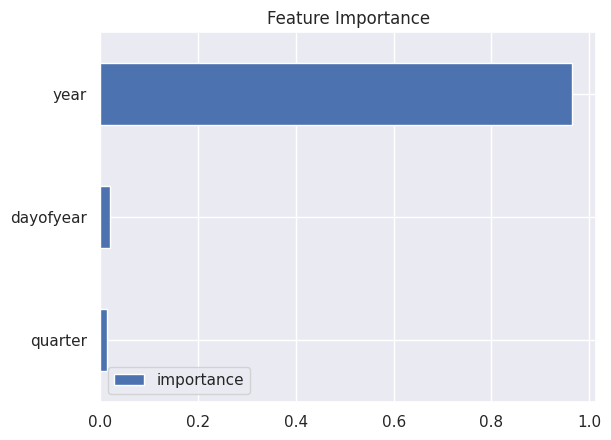

In [28]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [29]:
test["prediction"] = reg.predict(X_test)
btc_df = btc_df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

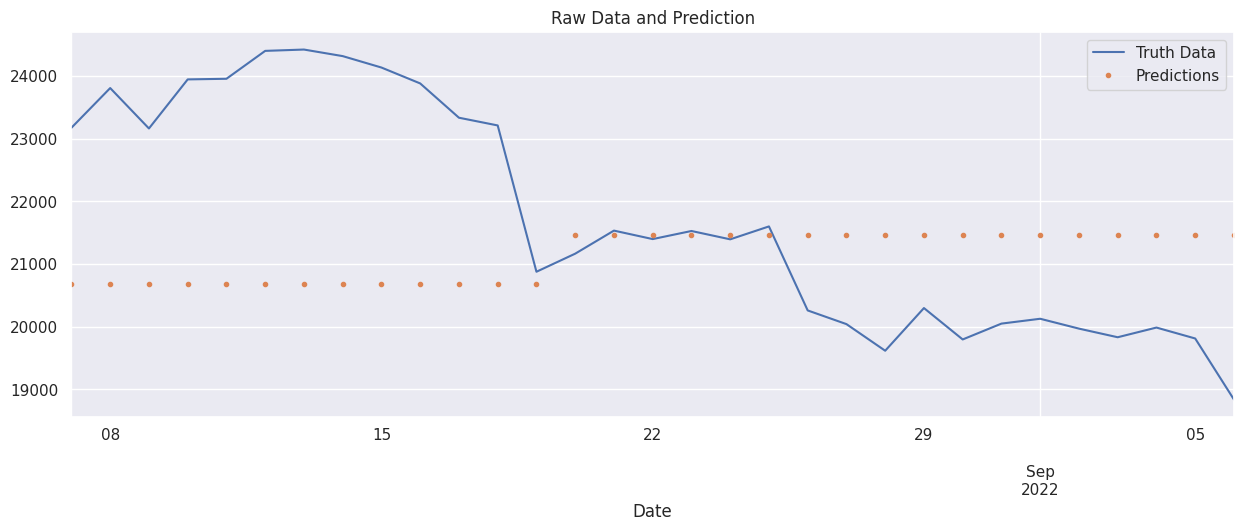

In [30]:
ax = btc_df[["Adj Close"]][btc_df.index >= split_date_point].plot(figsize=(15,5))
btc_df["prediction"][btc_df.index >= split_date_point].plot(ax=ax, style=".")
ax.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Prediction")
plt.show()

In [31]:
mean_squared_error(test["Adj Close"], test["prediction"])

4894298.8618904855

In [32]:
score = np.sqrt(mean_squared_error(test["Adj Close"], test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 2212.31


In [33]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    
    target_map = df["Adj Close"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("30 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("60 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("90 days")).map(target_map)
    
    return df

In [34]:
btc_df2 = btc_data[["Adj Close"]]

In [35]:
split_date_point = btc_df2.index.max() - pd.Timedelta(days=30)
data_filter_less = btc_df2.index < split_date_point
data_filter_geq = btc_df2.index >= split_date_point

train2 = btc_df2.loc[data_filter_less]
test2 = btc_df2.loc[data_filter_geq]

In [36]:
btc_df2 = create_features(df=btc_df2)
train2 = create_features(df=train2)
test2 = create_features(df=test2)
btc_df_with_lags = add_lags(df=btc_df2)
train_with_lags = add_lags(df=train2)
test_with_lags = add_lags(df=test2)

In [37]:
FEATURES = [column for column in btc_df2.columns[1:]]
TARGET = btc_df2.columns[0]

In [38]:
X_train = train_with_lags[FEATURES]
y_train = train_with_lags[TARGET]

X_test = test_with_lags[FEATURES]
y_test = test_with_lags[TARGET]

In [39]:
reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree", 
                           n_estimators=1000, early_stopping_rounds=50,
                           objective="reg:linear", max_depth=3,
                           learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)

[18:01:06] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20541.98413	validation_1-rmse:21388.19485
[100]	validation_0-rmse:8122.43518	validation_1-rmse:10022.50875
[200]	validation_0-rmse:3727.74601	validation_1-rmse:6806.22640
[300]	validation_0-rmse:2331.54893	validation_1-rmse:6104.65488
[400]	validation_0-rmse:1849.81884	validation_1-rmse:5737.42156
[500]	validation_0-rmse:1635.16413	validation_1-rmse:5314.21470
[600]	validation_0-rmse:1517.60243	validation_1-rmse:5166.11901
[700]	validation_0-rmse:1456.61858	validation_1-rmse:4752.47048
[800]	validation_0-rmse:1414.72345	validation_1-rmse:4683.46933
[830]	validation_0-rmse:1395.20000	validation_1-rmse:4711.77685


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

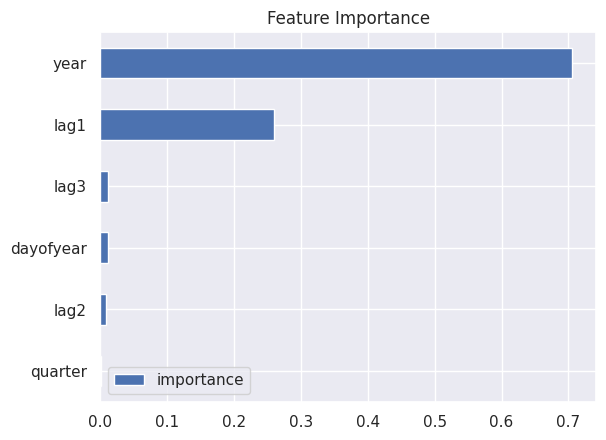

In [40]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [41]:
test_with_lags["prediction"] = reg.predict(X_test)
btc_df2 = btc_df2.merge(test_with_lags[["prediction"]], how="left", left_index=True, right_index=True)

In [42]:
btc_df2

,Adj Close,quarter,year,dayofyear,lag1,lag2,lag3,prediction
Date,,,,,,,,
2014-09-17,457.334015,3,2014,260,NaN,NaN,NaN,NaN
2014-09-18,424.440002,3,2014,261,NaN,NaN,NaN,NaN
2014-09-19,394.795990,3,2014,262,NaN,NaN,NaN,NaN
2014-09-20,408.903992,3,2014,263,NaN,NaN,NaN,NaN
2014-09-21,398.821014,3,2014,264,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-09-02,19969.771484,3,2022,245,22846.507812,20231.261719,29832.914062,17439.396484
2022-09-03,19832.087891,3,2022,246,22630.957031,20190.115234,29906.662109,17439.396484
2022-09-04,19986.712891,3,2022,247,23289.314453,20548.246094,31370.671875,17439.396484


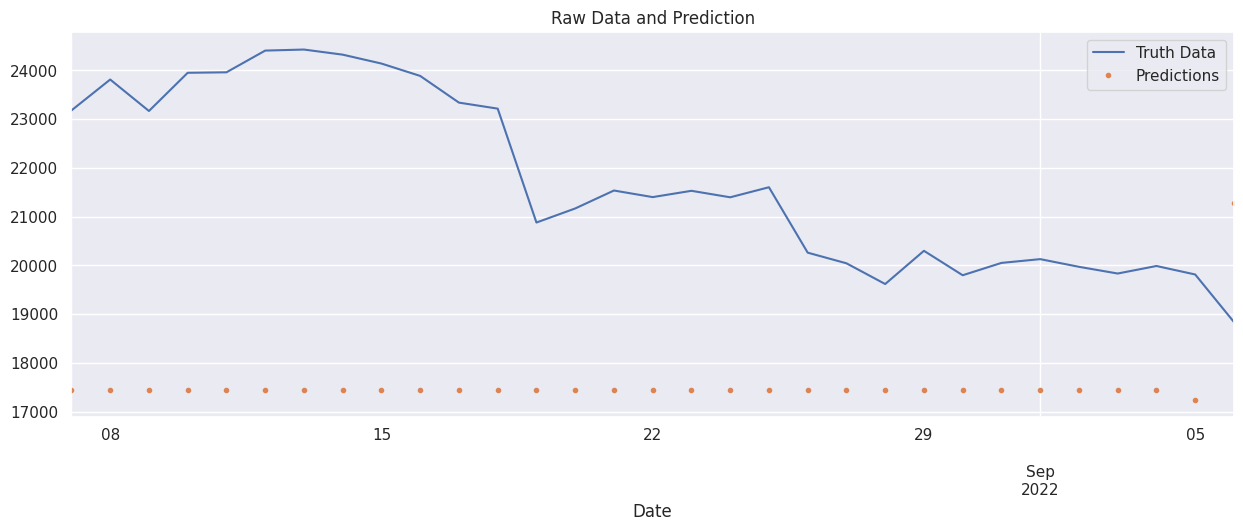

In [43]:
ax = btc_df2[["Adj Close"]][btc_df2.index >= split_date_point].plot(figsize=(15,5))
btc_df2["prediction"][btc_df2.index >= split_date_point].plot(ax=ax, style=".")
ax.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Prediction")
plt.show()

In [44]:
mean_squared_error(test_with_lags["Adj Close"], test_with_lags["prediction"])

21820837.429900263

In [45]:
score = np.sqrt(mean_squared_error(test_with_lags["Adj Close"], test_with_lags["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 4671.28
